In [1]:
import collections

import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline

import libs.utils as utils

In [2]:
height = 100
width = 100
channel = 3

In [3]:
def load_imgs(dir_path):
    name_list = os.listdir(dir_path)
    
    img_list = []
    
    for name in name_list:
        img_path = "{}/{}".format(dir_path, name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(width,height))
        img_list.append(img)
    return img_list

In [4]:
img_list = load_imgs("./data/celeb")

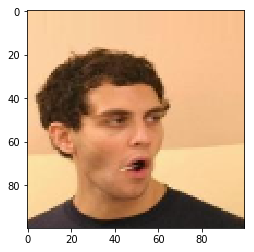

In [5]:
plt.imshow(img_list[0])

In [6]:
def blur_img_list(img_list):
    result_list =[]
    for img in img_list:
        result = cv2.GaussianBlur(img,(15,15), 1)
        result_list.append(result)
    return result_list

In [7]:
X_train = np.array(blur_img_list(img_list))
Y_train = np.array(img_list)

In [8]:
mean_img = np.mean(Y_train, axis=0)
std_img = np.std(Y_train, axis=0)

In [9]:
test_img = ((X_train-mean_img)/std_img)

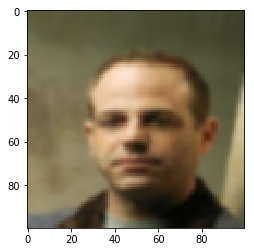

In [10]:
plt.imshow(X_train[10])

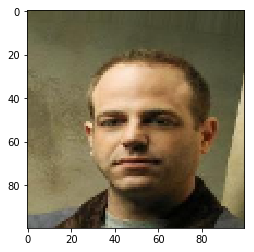

In [11]:
plt.imshow(Y_train[10])

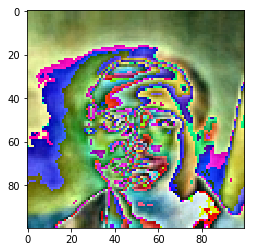

In [12]:
plt.imshow(test_img[10])

In [13]:
tf.reset_default_graph()

In [14]:
def conv2d(X, n_input, n_output, filter_size, name):
    
    with tf.variable_scope(name):
        W = tf.get_variable(
                    name='W_1',
                    shape=[filter_size[0],filter_size[1],n_input,n_output],
                    initializer=tf.contrib.layers.xavier_initializer_conv2d())

        b = tf.get_variable(
                    name='b_1',
                    shape=[n_output],
                    initializer=tf.constant_initializer(0.))
        
        conv = tf.nn.conv2d(X,
                            W, 
                            strides= [1,1,1,1],
                            padding='SAME'
                           )
        h = tf.nn.relu(tf.nn.bias_add(conv,b))
    
    return h

In [15]:
def build_model():

    
    n_flat = height * width * channel
    X = tf.placeholder(tf.float32, shape=[None, height,width,channel],name='X')
    Y = tf.placeholder(tf.float32, shape=[None, height,width,channel], name='Y')
    
    start_learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    global_step = tf.Variable(0, trainable=False)
    
    layer_info_list = [
        {'name':'conv_1',
                    'n_input':3,
                    'n_output':128,
                    'filter_size':(3,3)},
        {'name':'conv_2',
                    'n_input':128,
                    'n_output':64,
                    'filter_size':(1,1)},
        {'name':'conv_3', 
                    'n_input':64,
                    'n_output':3,
                    'filter_size':(3,3)},
            ]
    
    current_input = X
    
    for info in layer_info_list:
        
        current_input = conv2d(X=current_input,
                                   n_input=info['n_input'],
                                   n_output=info['n_output'],
                                   filter_size=info['filter_size'],
                                   name=info['name'],
                                  )
    Y_pred = current_input
    
    Y_pred_flattened = tf.reshape(Y_pred, shape=[-1,n_flat ])
    Y_flattened = tf.reshape(Y, shape=[-1,n_flat])
    
    
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step,
                                               10000, 0.96, staircase=True)
    
    cost = tf.reduce_mean(tf.reduce_sum(tf.squared_difference(Y_pred_flattened, Y_flattened),axis=1), axis=0)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    return X, Y, Y_pred, cost, optimizer, start_learning_rate


In [16]:
def train(X_train, Y_train, X, Y, Y_pred, cost, optimizer, start_learning_rate,sess = None):

    batch_size = 12
    n_epoch = 5000
    
    if sess == None :
        sess = tf.Session()

        sess.run(tf.global_variables_initializer())

    for epoch_i in range(n_epoch):
        print("epoh_i : {}".format(epoch_i))
        rand_idx_list = np.random.permutation(range(len(X_train)))
        n_batch = len(rand_idx_list) // batch_size
        for batch_i in range(n_batch):

            rand_idx = rand_idx_list[batch_i*batch_size : (batch_i+1)*batch_size]
            batch_x = X_train[rand_idx]
            batch_y = Y_train[rand_idx]
            sess.run(optimizer, feed_dict={X:(batch_x-mean_img)/std_img, Y: (batch_y-mean_img)/std_img,
                                              start_learning_rate : 0.001})

        if epoch_i % 10 == 0 :
            test_img = X_train[0]
            test_img = np.reshape(test_img, [-1,height, width,channel])
            Y_train_pred = Y_pred.eval(feed_dict={X:(test_img-mean_img)/std_img },session=sess)
            training_cost = sess.run(cost, feed_dict={X:(X_train-mean_img)/std_img,Y:(Y_train-mean_img)/std_img})

            Y_train_pred = np.reshape(Y_train_pred, [height,width, channel])
            Y_train_pred = Y_train_pred*std_img +mean_img
            Y_train_pred = np.clip(Y_train_pred, 0, 255)

            plt.imshow(Y_train_pred.astype(np.uint8))
            plt.show()
            print("training_cost : {}".format(training_cost))
        
    return sess

In [17]:
X, Y, Y_pred, cost, optimizer,start_learning_rate = build_model()

In [ ]:
sess = train(X_train, Y_train, X, Y, Y_pred, cost, optimizer,start_learning_rate)

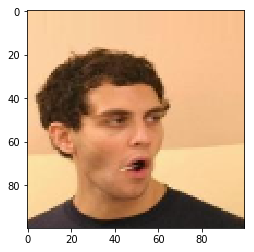

In [18]:
plt.imshow(img_list[0])

In [ ]:
a = (X_train[10]-mean_img)/std_img
a = a.reshape([1,height, width, channel])
result = sess.run(Y_pred, feed_dict={X:a})

In [ ]:
result = np.reshape(result, [height,width, channel])
result = result*std_img +mean_img
result = np.clip(result, 0, 255)

In [ ]:
plt.imshow(X_train[10])

In [ ]:
plt.imshow(result.astype(np.uint8))

In [ ]:
plt.imshow(Y_train[10])

In [ ]:
sess.close()

In [ ]:
rand_idx = np.random.permutation(range(len(X_train)))

In [ ]:
n_batch = len(rand_idx) // 6

In [ ]:
n_batch

In [ ]:
len(rand_idx)

In [ ]:
Y_train.shape

In [ ]:
X_train.shape